In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D


In [ ]:
# Create images with white backgrounds
import plotly.io as pio
pio.templates.default = 'plotly_white'

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='DATA.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('DATA.zip')

In [ ]:
!unzip DATA.zip

Streaming output truncated to the last 5000 lines.
  inflating: DATA/20/Undamage/20_original_105.jpg_7d6afb3b-d55d-4367-99a4-bf34d5b0bcde.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_7eed3cb5-ff8b-485c-853c-91f258928bb3.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_9abe295c-047a-47c6-b7d3-c9a3f7dcea0b.jpg  
  inflating: DATA/20/Undamage/20_original_105.jpg_defc6234-e1c1-4a2f-968a-6fa36b6d6310.jpg  
  inflating: DATA/20/Undamage/20_original_106.jpg_3fb75a03-0995-40e8-ab9f-895c2ef7a7f8.jpg  
  inflating: DATA/20/Undamage/20_original_106.jpg_9bcf9ec5-c048-4a80-90bb-09463d13ad89.jpg  
  inflating: DATA/20/Undamage/20_original_106.jpg_ca6fa753-dde5-4bcd-8ae3-236832872b9e.jpg  
  inflating: DATA/20/Undamage/20_original_107.jpg_7aaf5559-2bcf-4aab-94ba-e05428f4dbbe.jpg  
  inflating: DATA/20/Undamage/20_original_108.jpg_4cf70d7b-bbaa-4ba3-a902-bffff64d4f03.jpg  
  inflating: DATA/20/Undamage/20_original_108.jpg_60a50e4f-bafa-4244-b640-7da401aa77a4.jpg  
  inflating: DATA/2

In [ ]:
PATH = '/content/DATA'

In [ ]:
IMG_HEIGHT = 212
IMG_WIDTH = 212
batch_size = 64



In [ ]:
# Image preprocessing
image_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [ ]:
train_data_gen = image_gen.flow_from_directory(
    directory=PATH,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',  # For the denomination classification
    subset='training'
)

val_data_gen = image_gen.flow_from_directory(
    directory=PATH,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='categorical',  # For the denomination classification
    subset='validation'
)

Found 9887 images belonging to 4 classes.
Found 2471 images belonging to 4 classes.


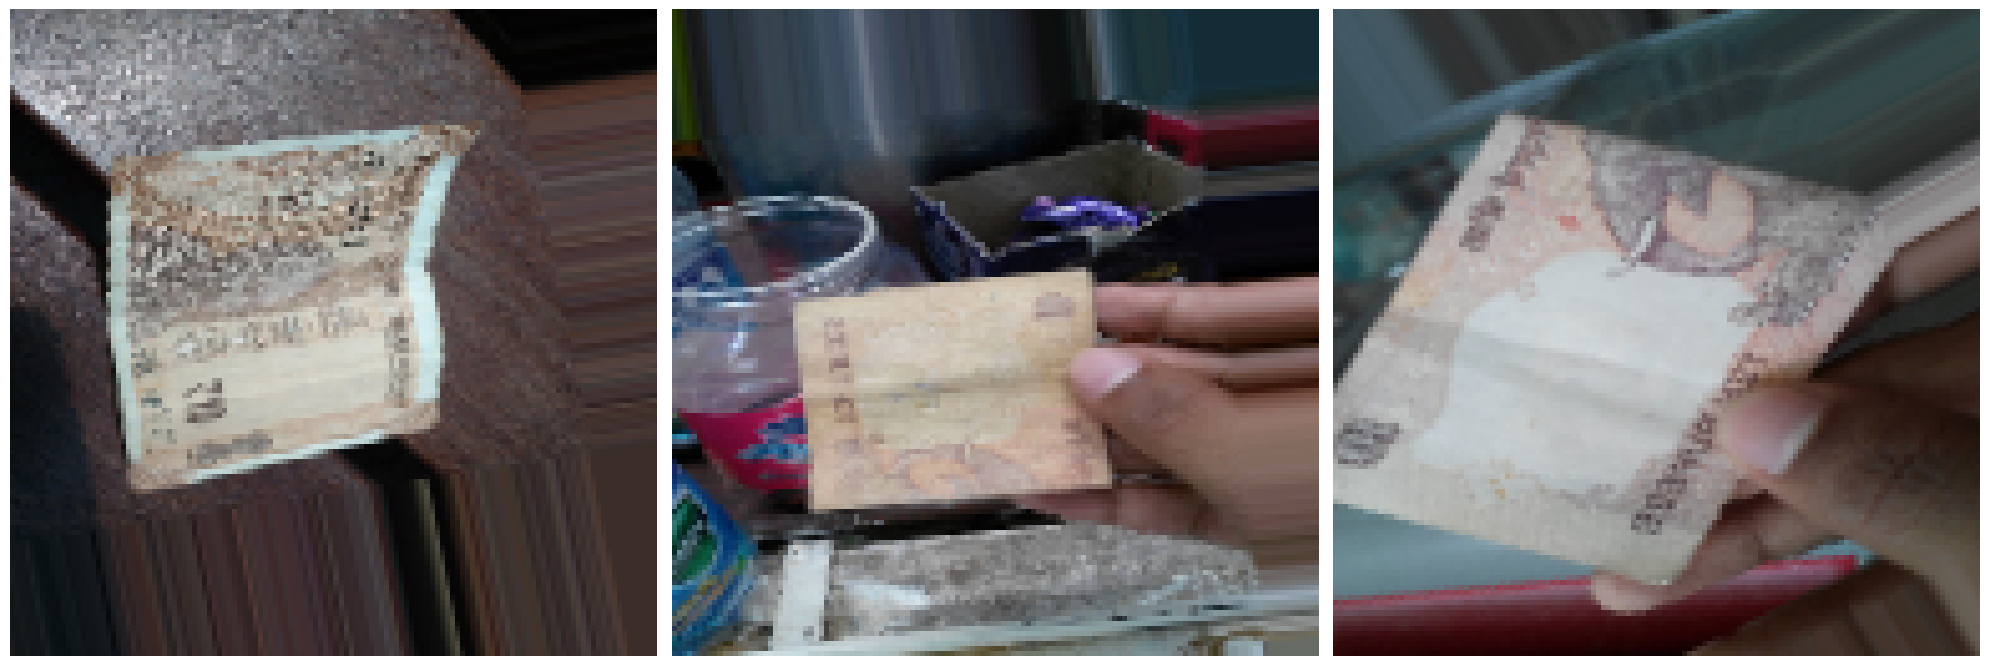

In [ ]:
# Visualize sample training images
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[1:5])

In [ ]:
# Calculate Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data_gen.classes),
    y=train_data_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Model definition

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = Conv2D(64, 3, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(128, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.4)(x)

x = Conv2D(256, 3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)
x = Dropout(0.4)(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
x = Dropout(0.5)(x)

In [ ]:

# Denomination classification output
denomination_output = Dense(4, activation='softmax', name='denomination_output')(x)  # Assuming 7 denominations


In [ ]:
# Damage detection output
damage_output = Dense(128, activation='relu')(x)
damage_output = Dense(1, activation='sigmoid', name='damage_output')(damage_output)


In [ ]:
from tensorflow.keras.optimizers import RMSprop

In [ ]:

# Compile the model
model = Model(inputs=inputs, outputs=denomination_output)
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ denomination_output (Dense)          │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 506,244 (1.93 MB)

 Trainable params: 505,348 (1.93 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),
    EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=7,
        restore_best_weights=True
    )
]


In [ ]:

epochs = 30
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

In [ ]:
import matplotlib.pyplot as plt

# 1. Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['denomination_output_accuracy'], label='Training Accuracy (Denomination)')
    plt.plot(history.history['val_denomination_output_accuracy'], label='Validation Accuracy (Denomination)')
    plt.title('Denomination Classification Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_accuracy(history)


"import matplotlib.pyplot as plt\n\n# 1. Plot training and validation accuracy\ndef plot_accuracy(history):\n    plt.figure(figsize=(12, 6))\n    plt.plot(history.history['denomination_output_accuracy'], label='Training Accuracy (Denomination)')\n    plt.plot(history.history['val_denomination_output_accuracy'], label='Validation Accuracy (Denomination)')\n    plt.title('Denomination Classification Accuracy')\n    plt.xlabel('Epochs')\n    plt.ylabel('Accuracy')\n    plt.legend()\n    plt.show()\nplot_accuracy(history)"

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize
    return img_array


In [ ]:

def generate_gradcam_heatmap(model, image, layer_name, output_index=0):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        image = tf.cast(image, tf.float32)
        tape.watch(image)
        conv_output, predictions = grad_model(image)

        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]


    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)


    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap + 1e-8)

    return heatmap


In [ ]:
def overlay_gradcam(image, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_image = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_image

In [ ]:
def preprocess_damage_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 150, 250)


    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

    img_with_damage = img.copy()
    cv2.drawContours(img_with_damage, valid_contours, -1, (0, 255, 0), 2)

    return img_with_damage, len(valid_contours) > 0



In [ ]:
def display_prediction_with_heatmap(model, img_path, denomination_mapping, layer_name='conv2d_2'):

    img_array = load_and_preprocess_image(img_path)
    original_img = cv2.imread(img_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)


    heatmap = generate_gradcam_heatmap(model, img_array, layer_name=layer_name)
    superimposed_img = overlay_gradcam(original_img_rgb, heatmap)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

    predictions = model.predict(img_array)
    denomination_pred_index = np.argmax(predictions[0])
    denomination_pred = denomination_mapping[denomination_pred_index]

    _, is_damaged = preprocess_damage_image(img_path)
    damage_status = "Damaged" if is_damaged else "Undamaged"


    plt.figure(figsize=(6, 6))
    plt.imshow(original_img_rgb)
    plt.title(f'Denomination: {denomination_pred}, Damage: {damage_status}')
    plt.axis('off')
    plt.show()


In [ ]:
denomination_mapping = [10, 20, 50, 100]

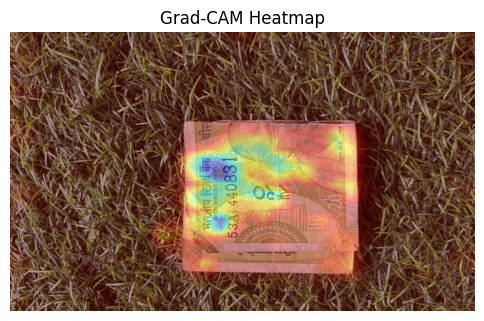

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


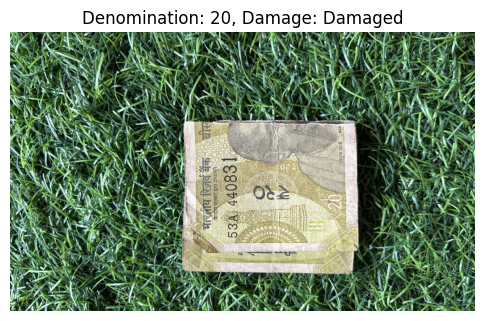

In [ ]:
img_path = '/content/DATA/20/Damage/20_new_369.jpg'
display_prediction_with_heatmap(model, img_path, denomination_mapping)


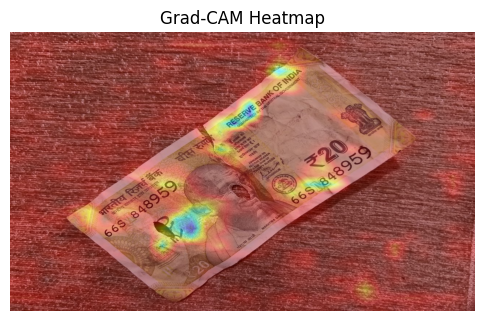

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


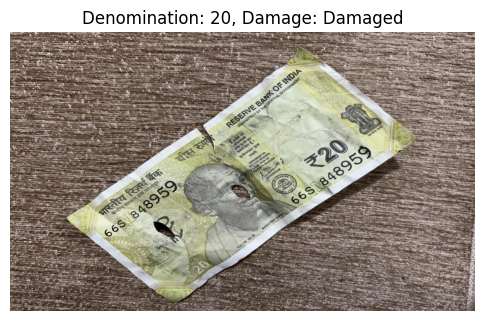

In [ ]:
img_path = '/content/DATA/20/Damage/20_new_286.jpg'
display_prediction_with_heatmap(model, img_path, denomination_mapping)


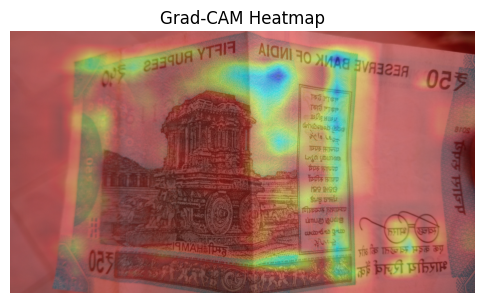

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


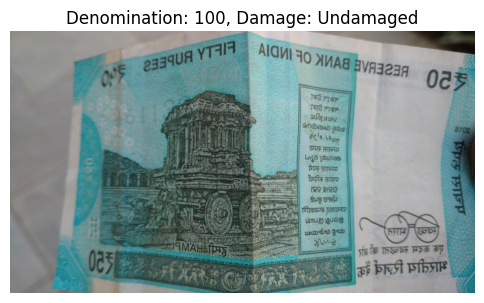

In [ ]:
img_path = '/content/DATA/50/Undamage/50_original_IMG_20190421_070335748.jpg_9967c4b5-5544-4f7d-a9a2-6a6410ff6084.jpg'
display_prediction_with_heatmap(model, img_path, denomination_mapping)

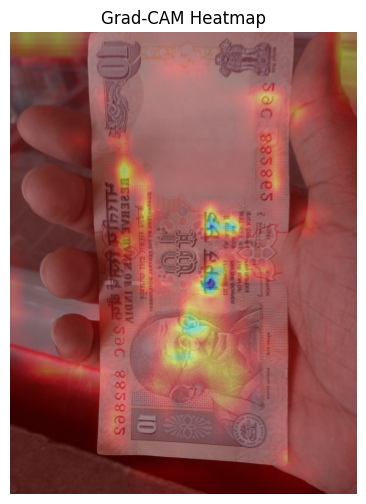

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


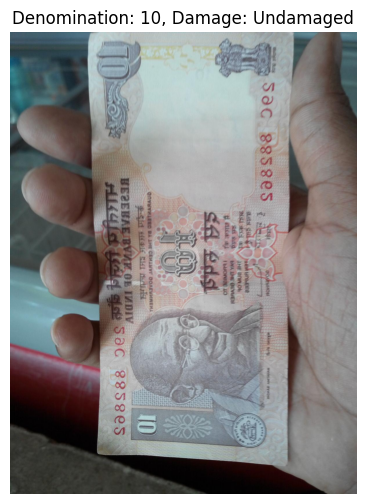

In [ ]:
img_path = '/content/DATA/10/Undamage/10_original_176.jpg_38e91f3c-743a-402c-881c-fd7728a7e3b9.jpg'
display_prediction_with_heatmap(model, img_path, denomination_mapping)

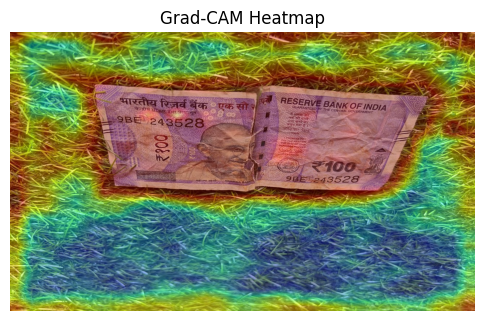

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


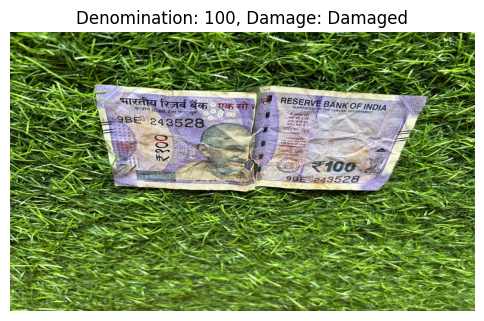

In [ ]:
img_path = '/content/DATA/100/Damage/100_new_369.jpg'
display_prediction_with_heatmap(model, img_path, denomination_mapping)


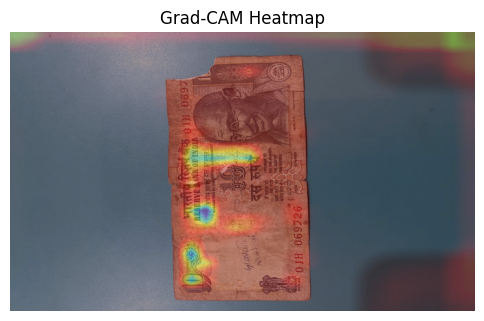

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


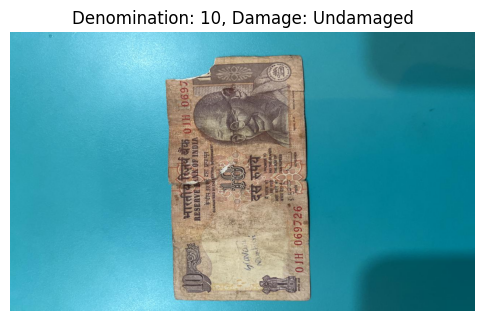

In [ ]:
img_path = '/content/DATA/10/Damage/10_old_34.jpg'
display_prediction_with_heatmap(model, img_path, denomination_mapping)